### Exploring Trends in the Spread of Misinformation
What trends might we uncover by isolating the tweets denying climate change?  Are there any patterns to find that would help make sense of the spread of misinformation on social media?  What connection is there (if any) between climate change denial and negative sentiment in Twitter posts on this subject?

#### Initial set up:

In [126]:
# Import dependencies

import os
import hvplot.pandas
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from citipy import citipy

# Remove warnings for saving map file

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

#### Import and format dataset:

In [127]:
# Read csv file

deniers = os.path.join('..','Resources', 'Climate_Deniers.csv')
deniers_data = pd.read_csv(deniers)

# Convert to appropriate data types & extract date column

deniers_data['created_at'] = deniers_data['created_at'].astype('datetime64')
deniers_data['date'] = deniers_data['created_at'].dt.to_period('M')

# Organize columns & display data

denier_twts = deniers_data.loc[:, ['date', 'lat', 'lng', 'topic', 'sentiment', 'aggressiveness', 'gender', 'created_at']]
print(denier_twts.dtypes)
denier_twts.head()

date                   period[M]
lat                      float64
lng                      float64
topic                     object
sentiment                float64
aggressiveness            object
gender                    object
created_at        datetime64[ns]
dtype: object


,date,lat,lng,topic,sentiment,aggressiveness,gender,created_at
0,2006-12,36.072640,-79.791980,Weather Extremes,-0.565028,aggressive,male,2006-12-17 19:43:09
1,2007-01,36.112637,-80.014484,Weather Extremes,-0.377974,aggressive,male,2007-01-18 13:22:52
2,2007-01,25.963890,-80.244170,Weather Extremes,0.567071,not aggressive,undefined,2007-01-24 10:13:18
3,2007-03,30.287986,-97.778898,Weather Extremes,-0.253728,not aggressive,male,2007-03-03 15:23:53
4,2007-03,37.779026,-122.419906,Weather Extremes,-0.433604,aggressive,male,2007-03-13 23:03:07


### Geographic Trends in Early Climate Denier Tweets:

In [128]:
# Group by topics & get the first few posts for each

all_topics = denier_twts.groupby('topic')['created_at'].nsmallest(5)

# Merge this set with original df to get the info for each post

use_this = pd.merge(all_topics, denier_twts, how='left')


""" If you would like to see only one topic on the below map: change the string in the 
following code:
Topic options include:
    Donald Trump versus Science, Global stance, Weather Extremes,
    Ideological Positions on Global Warming, Impact of Resource Overconsumption, 
    Importance of Human Intervantion, Politics, Seriousness of Gas Emissions, 
    Significance of Pollution Awareness Events, Undefined / One Word Hashtags """

one_topic = use_this[use_this['topic'] == "Donald Trump versus Science"]  # <-- Add topic here

""" uncomment the next code line to activate above topic instead of all topics """

#use_this = one_topic.copy()


# Get nearest city to each tweet for context

use_this['city'] = ""
for index, row in use_this.iterrows():
    use_this.loc[index, 'city'] = citipy.nearest_city(row['lat'], row['lng']).city_name


# Pull the first tweet in each group to see where the conversation originated

frst = use_this.groupby('topic')['created_at'].min()
first_twts = pd.merge(frst, use_this, how='left')

# Display results

print(len(use_this))
srt = use_this.sort_values('topic', ascending=False)
first_twts

50


,created_at,date,lat,lng,topic,sentiment,aggressiveness,gender,city
0,2007-04-06 08:17:31,2007-04,35.227209,-80.843083,Donald Trump versus Science,-0.604242,not aggressive,male,charlotte
1,2007-03-31 12:16:59,2007-03,35.227090,-80.843130,Global stance,-0.404815,not aggressive,male,charlotte
2,2007-04-07 15:26:24,2007-04,30.271129,-97.743700,Ideological Positions on Global Warming,-0.515978,not aggressive,male,austin
3,2007-05-02 17:11:53,2007-05,50.666480,-120.319200,Impact of Resource Overconsumption,-0.690117,aggressive,male,kamloops
4,2007-04-20 18:17:23,2007-04,42.081156,-87.980216,Importance of Human Intervantion,-0.359227,aggressive,male,arlington heights
5,2007-08-19 13:33:24,2007-08,51.508530,-0.125740,Politics,-0.295054,aggressive,male,london
6,2007-04-12 03:40:27,2007-04,27.947520,-82.458430,Seriousness of Gas Emissions,-0.456556,aggressive,male,tampa
7,2007-10-03 06:57:04,2007-10,-27.467940,153.028090,Significance of Pollution Awareness Events,-0.737047,aggressive,male,brisbane
8,2007-07-12 17:49:09,2007-07,38.895110,-77.036370,Undefined / One Word Hashtags,0.761608,not aggressive,male,washington
9,2006-12-17 19:43:09,2006-12,36.072640,-79.791980,Weather Extremes,-0.565028,aggressive,male,greensboro


In [129]:
%%capture --no-display

# Plot points of earliest tweets on each topic

map1 = srt.hvplot.points(
    "lng",
    "lat",
    coastline = True,
    tiles = "OSM",
    frame_width = 550,
    frame_height = 350,
    hover_cols = ["lat", "lng", "topic", "city"],
    s = 90,
    color = "topic",
    alpha = .8,
    title = "Earliest 5 Tweets on Climate Change by Topic/Location"
) 

# Plot a white circle in the middle of the first tweet sent for each topic to highlight them

map2 = first_twts.hvplot.points(
    "lng",
    "lat",
    geo=True,
    frame_width = 550,
    frame_height = 350,
    hover_cols = ["lat", "lng", "topic", "city"],
    s = 15,
    color = "white",
)

# Overlay both dataframes onto the same map plot

full = map1 * map2

# Save copy of map
try:
    hvplot.save(full, "../Images/Earliest-Tweets-Map.png")
except Exception as e:
    print(e)

# Display the map

full

:Overlay
   .Tiles.I     :Tiles   [x,y]
   .Points.I    :Points   [lng,lat]   (topic,city)
   .Coastline.I :Feature   [Longitude,Latitude]
   .Points.II   :Points   [lng,lat]   (topic,city)

#### Geographic Analysis:  
Climate denial has existed since the late ninties, well before Twitter first became publicly available in 2006.  From our dataset, we found that tweets about climate denial found their way onto the platform almost from the beginning, with the first tweet from a climate denier on the subject from December of that same year.

The above map shows the geolocation of the first 5 tweets about climate change from the stance of "Denier" on each subtopic as shown in the legend to the right.  The locations highlighted with a white circle are the first tweets on each subject, to show the origin point of the conversation.  What we notice is that most of these seem to originate in the US, and most of tweets originate in near-coastal regions.  From the above analysis, we can also see that many of these tweets are from large, highly populated cities as well.

There doesn't seem to be any major discernible pattern to the spread of the topics geographically, and this isn't very surpising given the medium of social media.  It's difficult to determine if this kind of distribution is related to the subject matter of climte change specifically, or to Twitter in general, but it does seem to be an interesting pattern that may merit further study.

### Trends in Climate Denier Sentiment/Aggression Over Time:

In [130]:
# Find quartiles of sentiment value

print(denier_twts['sentiment'].describe())

# Create bins to group sentiment by

bins = [-1, -.5, -.2, 0, 1]
names = ["Very Low", "Low", "Average", "High"]

# Cut dataset into sentiment groups by quartiles & display results

denier_twts['Sentiment'] = pd.cut(denier_twts['sentiment'], bins, labels=names, include_lowest=True)
denier_twts.head()

count    365317.000000
mean         -0.225414
std           0.384433
min          -0.989643
25%          -0.522066
50%          -0.331963
75%           0.030237
max           0.979194
Name: sentiment, dtype: float64


,date,lat,lng,topic,sentiment,aggressiveness,gender,created_at,Sentiment
0,2006-12,36.072640,-79.791980,Weather Extremes,-0.565028,aggressive,male,2006-12-17 19:43:09,Very Low
1,2007-01,36.112637,-80.014484,Weather Extremes,-0.377974,aggressive,male,2007-01-18 13:22:52,Low
2,2007-01,25.963890,-80.244170,Weather Extremes,0.567071,not aggressive,undefined,2007-01-24 10:13:18,High
3,2007-03,30.287986,-97.778898,Weather Extremes,-0.253728,not aggressive,male,2007-03-03 15:23:53,Low
4,2007-03,37.779026,-122.419906,Weather Extremes,-0.433604,aggressive,male,2007-03-13 23:03:07,Low


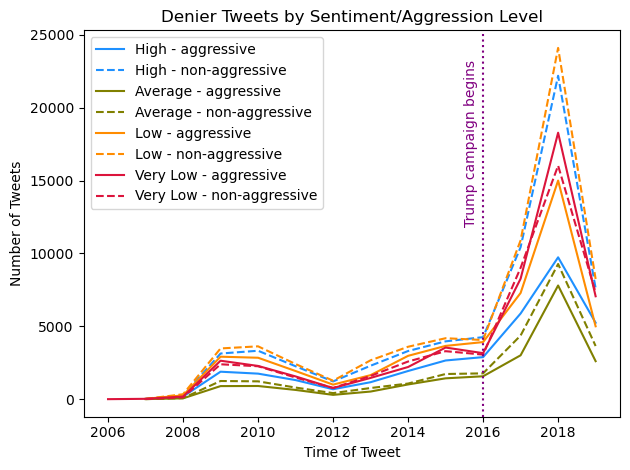

In [131]:
# Create 'years' column to group data by for broad overview plot

yrs = denier_twts['date'].dt.year
table = denier_twts.copy()
table['year'] = yrs

# Create function to plot lines for each sentiment bin level

def plot_sent(name, color):
    d1 = table.loc[(table['Sentiment'] == name) & (table['aggressiveness'] == 'aggressive'), :].reset_index(drop=True)
    d2 = table.loc[(table['Sentiment'] == name) & (table['aggressiveness'] != 'aggressive'), :].reset_index(drop=True)
    count = d1.groupby('year').count()
    count2 = d2.groupby('year').count()

    # Plot a solid line for aggressive tweets and dotted line for non-aggressive tweets

    count['topic'].plot(kind='line', color=color, label=name + " - aggressive")
    count2['topic'].plot(kind='line', color=color, linestyle="--", label=name + " - non-aggressive")

# Graph the lines in colors to represent the sentiment levels

plot_sent('High', 'dodgerblue')
plot_sent('Average', 'olive')
plot_sent('Low', 'darkorange')
plot_sent('Very Low', 'crimson')

# Add other graph elements & display results

plt.xlabel("Time of Tweet")
plt.ylabel("Number of Tweets")
plt.title("Denier Tweets by Sentiment/Aggression Level")

plt.axvline(2016, color='purple', linestyle=':')
plt.text(2015.5, 12000, 'Trump campaign begins', color='purple', rotation=90)

plt.legend(loc='best')
plt.tight_layout()
plt.savefig("../Images/Deniers-Sentiment-Overview.png")
plt.show()

#### Denier Sentiment/Aggression Analysis:  
This graph shows the total number of tweets from the stance "Denier" across the timeframe of the full dataset, grouped by sentiment level & aggression.  "Sentiment" was a somewhat difficult concept to grasp from the context of the original dataset documentation, but seems to refer to the sentiment of the tweet itself rather than the user's sentiment toward climate change, which is why we see a number of positive sentiment tweets from climate deniers, which would otherwise seem to be an oxymoron.  This is associated with people communicating with someone who agrees with them, and negative sentiment would be associated with arguments and disagreements.

What we see from the above graph is that both high and low sentiments are consistently favored across the whole timeframe, where average sentiments consistently remain along the bottom and less common.  This is what we would expect to see on a social media site, espeically during times of high engagement, where people are more likely to communicate with others and have strong emotions, rather than make neutral statements.

Another slightly more subtle pattern is that those with "Very Low" sentiment have a tendency to be aggressive more often than they are non-aggressive, particularly when the number of tweets are higher, or during "high engagement" time periods.

The overall shape of the number of tweets is very similar to what we see for users of all stances, which implies that this is either the shape of the conversation of climate change in general, the shape of the popularity of Twitter in general, or some combination of both.

### ANOVA: Relationship Between Stance and Sentiment

In [132]:
# Import file containing larger sample to compare deniers to other twitter users

sample5 = os.path.join('..','Resources', 'sample_05.csv')
frame5 = pd.read_csv(sample5)

# Create new dataframe with stance and sentiment

bx = frame5.loc[:, ['stance', 'sentiment']]
bx.head()

,stance,sentiment
0,neutral,0.602393
1,believer,-0.410768
2,believer,0.717759
3,believer,0.306821
4,believer,0.153192


In [133]:
# Get groups of each stance to run ANOVA test & display results

group1 = bx[bx['stance'] == 'believer']['sentiment']
group2 = bx[bx['stance'] == 'neutral']['sentiment']
group3 = bx[bx['stance'] == 'denier']['sentiment']

anova = stats.f_oneway(group1, group2, group3)
anova

F_onewayResult(statistic=9506.935741646466, pvalue=0.0)

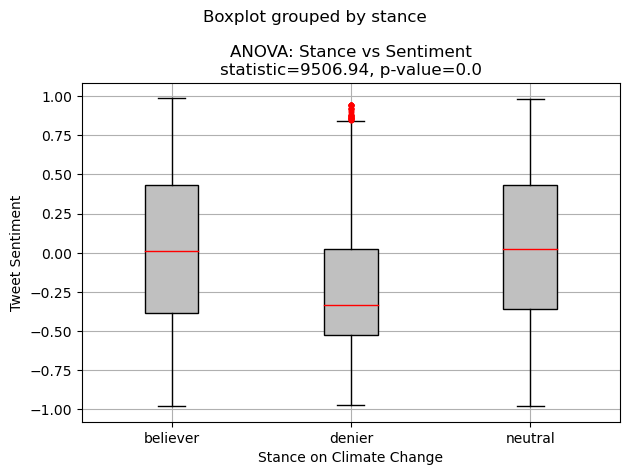

In [134]:
# Create boxplots of ANOVA results for visual confirmation

props = dict(medians="red", whiskers="black", caps="black")
boxprops = dict(fc = 'silver')
bx.boxplot('sentiment', by='stance', sym='r.', color=props, boxprops=boxprops, patch_artist=True)

# Add other elements to graph

plt.xlabel('Stance on Climate Change')
plt.ylabel('Tweet Sentiment')
plt.title(f'ANOVA: Stance vs Sentiment\nstatistic={round(anova[0],2)}, p-value={anova[1]}')

# Save file and display results

plt.tight_layout()
plt.savefig('../Images/ANOVA_results.png')
plt.show()

In [135]:
# Calculate IQR for denier tweets to determine range of potential outliers shown on graph

denier_quartiles = group3.quantile([.25, .5, .75])
lower = denier_quartiles[0.25]
upper = denier_quartiles[0.75]
iqr = upper-lower
upper_bnd = upper + (1.5 * iqr)

# Display results

print(f'Denier tweets with sentiment above {upper_bnd} appear as outliers')

Denier tweets with sentiment above 0.8455198454141618 appear as outliers


#### ANOVA Analysis:  
Finally, the above graph shows the results of an ANOVA test to check if there is a relationship between Twitter user stance and sentiment levels.  For this test we returned to the original dataset and took a random sampling of 5% of the total worldwide data (due to filesize constraints) in order to compare all stances.

What we see is a clear, significant difference in the mean sentiment of denier posts in comparison to all other posts from both believers and those expressing no stance on the subject of climate change.  These latter two both average a neutral sentiment, as would be expected, where the mean of the denier tweets falls much lower.  We also found that denier tweets with a sentiment above about 0.85 were likely to be outliers.

While this result is dramatic, it isn't necessarily surprising.  Denier tweets were about 8% of the total 15 million data points in the original dataset, and a minority group is likely to spend time debating with people who disagree with them more often than not simply due to being outnumbered.  However, it could also imply that deniers are spending more time trying to convince others to agree with them rather than communicating with those who already agree with them.  Futher study would be required to determine more information on that subject, but it is an interesting finding nonetheless.